### Monetary Circuit Flows
J M Applegate  

##### CAS543 Complexity Economics
This notebook implements the Monetary Circuit model from Keen 2010 discussed in the Monetary Circuit lecture as the original system of equations and then iteratively.

In [2]:
# import packages
import numpy as np
import random
import pandas
import itertools
import math
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import seaborn as sns
plt.rc('font',**{'family':'sans-serif','sans-serif':['Futura']})

In [3]:
# parameter values and equations from Keen 2010
beta_V = 3/4
r_L = .05
r_D = .02
phi_D = 2
beta_T = 1
omega_D = 26
phi_L = 1/7

def dS_dt(S, t):
    B_V, B_T, F_L, F_D, W_D = S  
    dB_V  = phi_L * F_L - beta_V * B_V  
    dB_T = r_L * F_L - r_D * F_D - r_D * W_D - beta_T * B_T  
    dF_L = beta_V * B_V - phi_L * F_L 
    dF_D = beta_V * B_V - r_L * F_L + r_D * F_D - phi_D * F_D + beta_T * B_T + omega_D * W_D - phi_L * F_L 
    dW_D = phi_D * F_D + r_D * W_D - omega_D * W_D
    return(dB_V, dB_T, dF_L, dF_D, dW_D)

steps = np.linspace(0, 10)
S_0 = [100, 0, 0, 0, 0]
solution = odeint(dS_dt, S_0, steps)

Replicating Keen 2010 Figure 2.

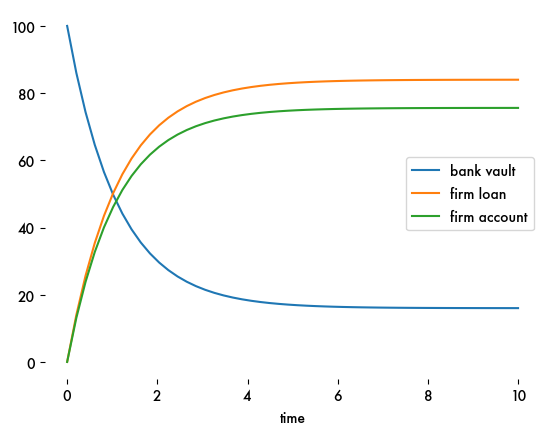

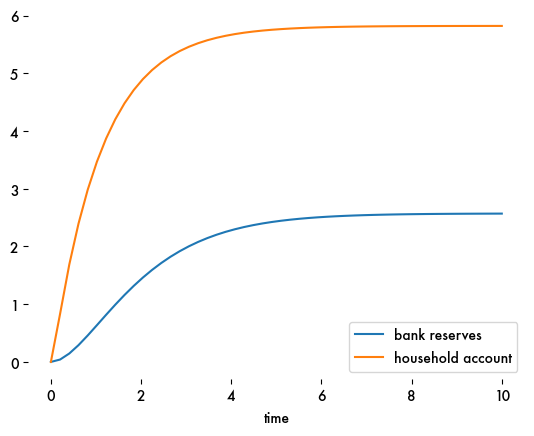

In [4]:
plt.plot(steps, solution[:, 0], label='bank vault');
plt.plot(steps, solution[:, 2], label='firm loan');
plt.plot(steps, solution[:, 3], label='firm account');
plt.legend();
plt.xlabel('time');
sns.despine(left = True, bottom = True)
plt.show()

plt.clf()

plt.plot(steps, solution[:, 1], label='bank reserves');
plt.plot(steps, solution[:, 4], label='household account');
plt.legend();
plt.xlabel('time');
sns.despine(left = True, bottom = True)

Values from Keen 2010 Equations 3 and 8.

In [9]:
def values(solution):
    B_V = solution[-1][0]
    F_L = solution[-1][2]
    F_D = solution[-1][3]
    W_D = solution[-1][4]
    B_T = solution[-1][1]
    print('B_V:', round(B_V, 4))
    print('F_L:', round(F_L, 4))
    print('F_D:', round(F_D, 4))
    print('W_D:', round(W_D, 4))
    print('B_T:', round(B_T, 4))
    return B_V, F_L, F_D, W_D, B_T
B_V, F_L, F_D, W_D, B_T = values(solution)

sigma = .4
tau_S = .3
wage_income = (1 - sigma) / tau_S * F_D + r_D * W_D
profit = sigma / tau_S * F_D + r_D * F_D - r_L * F_L
bank_income = r_L * F_L - r_D * (F_D + W_D)
print('wage income:', round(wage_income, 2))
print('profit:', round(profit, 2))
print('bank income:', round(bank_income, 2))

B_V: 16.0111
F_L: 83.9889
F_D: 75.6
W_D: 5.8198
B_T: 2.5691
wage income: 151.32
profit: 98.11
bank income: 2.57


The following code is based on the Keen 2010 model but implemented in a step-wise, interative manner with makes the flows visible.  
Some new variables were added in order to expicitly represent the timing of various transfers.

In [10]:
# set parameters
beta_V = 70 #bank lending frequency in weeks
r_L = .5 #loan interest rate
i_L = 52 #frequency of loan interest compounding in weeks
r_D = .2 #deposit interest rate
i_D = 52 #frequency of deposit interest compounding in weeks
tau_s = 16 #wages paid every 16 weeks (production cycle)
sigma = .4 #percentage of revenue retained for profit
beta_T = 52 #bank consumption frequency in weeks
omega_D = 2 #frequency of worker consumption in weeks
phi_L = 52 #frequency of loan repayment in weeks
rho_L = 1/7 #fraction of loan repaid in each repayment tranche
N = 100 #original number of lending notes created

# initally bank loans N out of vault to firm
B_V = 0
B_T = 0
F_D = N
W_D = 0
F_L = N 
revenue = 0
income = 0
profit = 0
worker_account = []
firm_account = []
bank_transaction_account = []
bank_vault = []
firm_loans = []
incomes = []
revenues = []
profits = []

# each time step is a week over the specified number of years
years = 10
steps = int(52 * years)

# save initial step values into list for plotting
worker_account.append(W_D)
firm_account.append(F_D)
bank_transaction_account.append(B_T)
bank_vault.append(B_V)
firm_loans.append(F_L)
incomes.append(income)
revenues.append(revenue)
profits.append(profit)

# sequential transfers between accounts according to timing parameters
for t in range(1, steps + 1):
    # bank lending
    if t % beta_V == 0: 
        F_D += B_V
        F_L += B_V
        B_V -= B_V
    # loan interest compounded and paid annually
    if t % i_L == 0:
        F_D -= r_L * F_L
        B_T += r_L * F_L
    # deposit interest payments
    if t % i_D == 0:
        B_T -= r_D * (F_D + W_D)
        F_D += r_D * F_D
        W_D += r_D * W_D
    # wage payments
    if t % tau_s == 0:
        W_D += (1 - sigma) * F_D
        income += (1 - sigma) * F_D
        profit += sigma * F_D
        F_D -= (1 - sigma) * F_D
    # worker consumption
    c = 1 #consumption proportion each spending cycle
    if t % omega_D == 0:
        F_D += c * W_D
        revenue += c * W_D
        W_D -= c * W_D
    # bank consumption
    if t % beta_T == 0:
        F_D += B_T
        revenue += B_T
        B_T -= B_T
    # loan repayment
    if t % phi_L == 0:
        F_D -= rho_L * F_L
        B_V += rho_L * F_L
        F_L -= rho_L * F_L
        
    # save current step values into list for plotting
    worker_account.append(W_D)
    firm_account.append(F_D)
    bank_transaction_account.append(B_T)
    bank_vault.append(B_V)
    firm_loans.append(F_L)
    incomes.append(income)
    revenues.append(revenue)
    profits.append(profit)

The first two graphs show the account balances like the original Keen model, the third the cumulative flows over time.

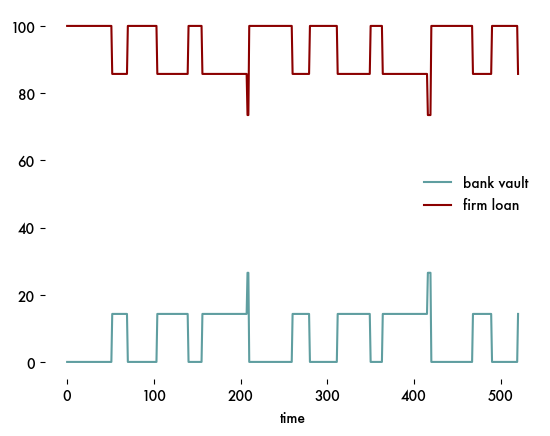

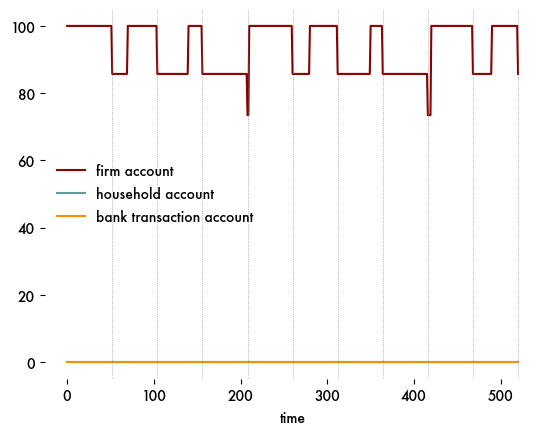

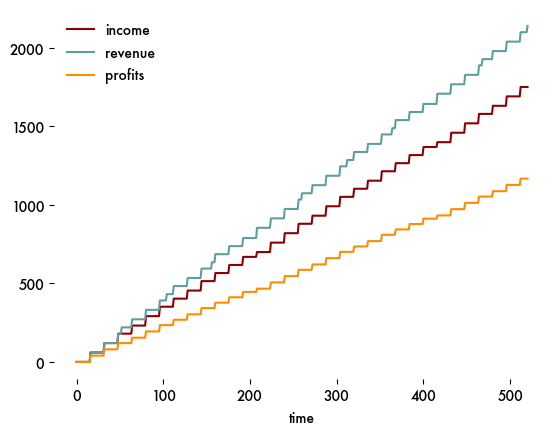

In [12]:
# plot results
plotting = np.array([bank_vault, firm_loans, firm_account, bank_transaction_account, worker_account, incomes, revenues, profits]).T
time = range(0, steps + 1)

plt.plot(time, plotting[:, 0], label='bank vault', c = 'cadetblue')
plt.plot(time, plotting[:, 1], label='firm loan', c = 'darkred')
plt.xlabel('time')
plt.legend(frameon=False)
sns.despine(left = True, bottom = True)
plt.show()

plt.clf()

plt.plot(time, plotting[:, 2], label='firm account', c = 'darkred')
plt.plot(time, plotting[:, 4], label='household account', c = 'cadetblue')
plt.plot(time, plotting[:, 3], label='bank transaction account', c = 'darkorange')
plt.xlabel('time')
plt.legend(frameon=False)
sns.despine(left = True, bottom = True)
[plt.axvline(x, linewidth=.5, linestyle = 'dotted', color='grey') for x in [w * 52 for w in range(1, years + 1)]]
plt.show()

plt.plot(time, plotting[:, 5], label='income', c = 'darkred')
plt.plot(time, plotting[:, 6], label='revenue', c = 'cadetblue')
plt.plot(time, plotting[:, 7], label='profits', c = 'darkorange')
plt.xlabel('time')
plt.legend(frameon=False)
sns.despine(left = True, bottom = True)
plt.show()

The final plot shows the cumulative flows over time (520 weeks).